In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Drzewa decyzyjne

## Wczytanie danych

In [29]:
train = pd.read_csv('ed-titanic-training.csv')
test = pd.read_csv('ed-titanic-test.csv')
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
train.loc[train['Age'] > 3, 'Age'] = 4
test.loc[test['Age'] > 3, 'Age'] = 4
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


## Korelacja Pearsona

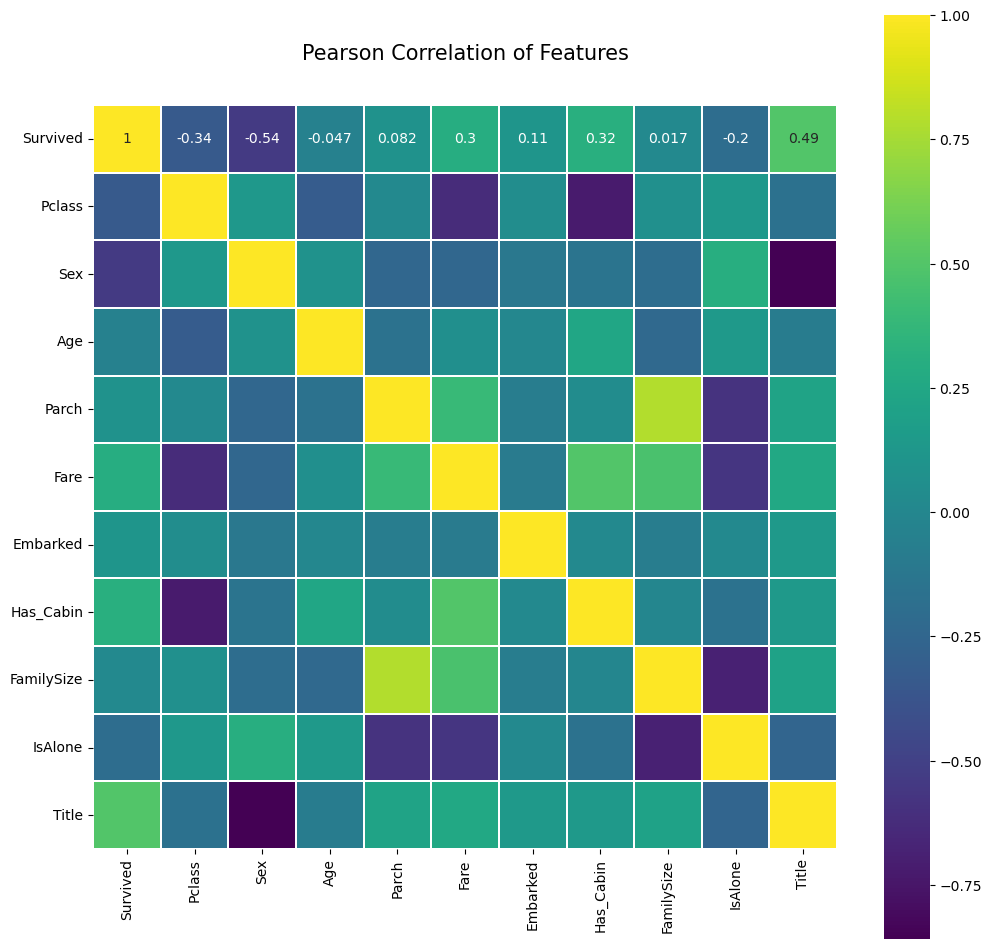

In [30]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

Z etykietą przeżycia najbardziej skorelowane są cechy takie jak:
- płeć (*Sex*),
- tytuł (*Title*),
- klasa miejsca (*Pclass),
- informacja o tym, czy pasażer miał własną kabinę (*Has_Cabin*),
- cena biletu

Najbardziej skorelowane ze sobą są cechy takie jak:
- tytuł (*Title*) i płeć (*Sex*),
- informacja o tym, czy ktoś podróżuje z dzieckiem lub rodzicem (*Parch*) i wielkość rodziny (*FamilySize*),
- klasa miejsca (*Pclass*) i informacja o posiadaniu kabiny (*Has_Cabin*),
- klasa miejsca (*Pclass*) i cena biletu (*Fare*)

## Wyznaczanie współczynnika przeżywalności w zależności od tytułu

In [31]:
titles = {
    1: 'Mr',
    2: 'Master',
    3: 'Mrs',
    4: 'Miss',
    5: 'Rare'
}
grouping = train.groupby(by=['Title'])['Survived'].mean()
grouping.index = titles.values()
grouping 

Mr        0.156673
Master    0.575000
Mrs       0.793651
Miss      0.702703
Rare      0.347826
Name: Survived, dtype: float64

Można zauważyć, że współczynnik przeżywalności jest zdecydowanie wyższy u kobiet (*Mrs* i *Miss*).

## Wyznaczanie optymalnej głębokości drzewa

In [32]:
data_x = train.drop('Survived', axis=1)
data_y = train['Survived']

In [33]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
search = GridSearchCV(
    DecisionTreeClassifier(),
    {
        'criterion': ['gini'],
        'max_depth' : np.arange(1, 15)
    },
    cv=10,
    scoring='accuracy'
)
search.fit(data_x, data_y)
print(search.best_estimator_.max_depth)

3


In [34]:
search = GridSearchCV(
    DecisionTreeClassifier(),
    {
        'criterion': ['entropy'],
        'max_depth' : np.arange(1, 15)
    },
    cv=10,
    scoring='accuracy'
)
search.fit(data_x, data_y)
print(search.best_estimator_.max_depth)

3


## Budowa drzewa decyzyjnego

In [35]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier(max_depth = 3,
criterion='entropy')
decision_tree.fit(data_x, data_y)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

## Predykcja możliwości przeżycia

In [36]:
predictions = decision_tree.predict(test)

test['Survived'] = predictions
test.to_csv('titanic_predictions.csv', index=False)

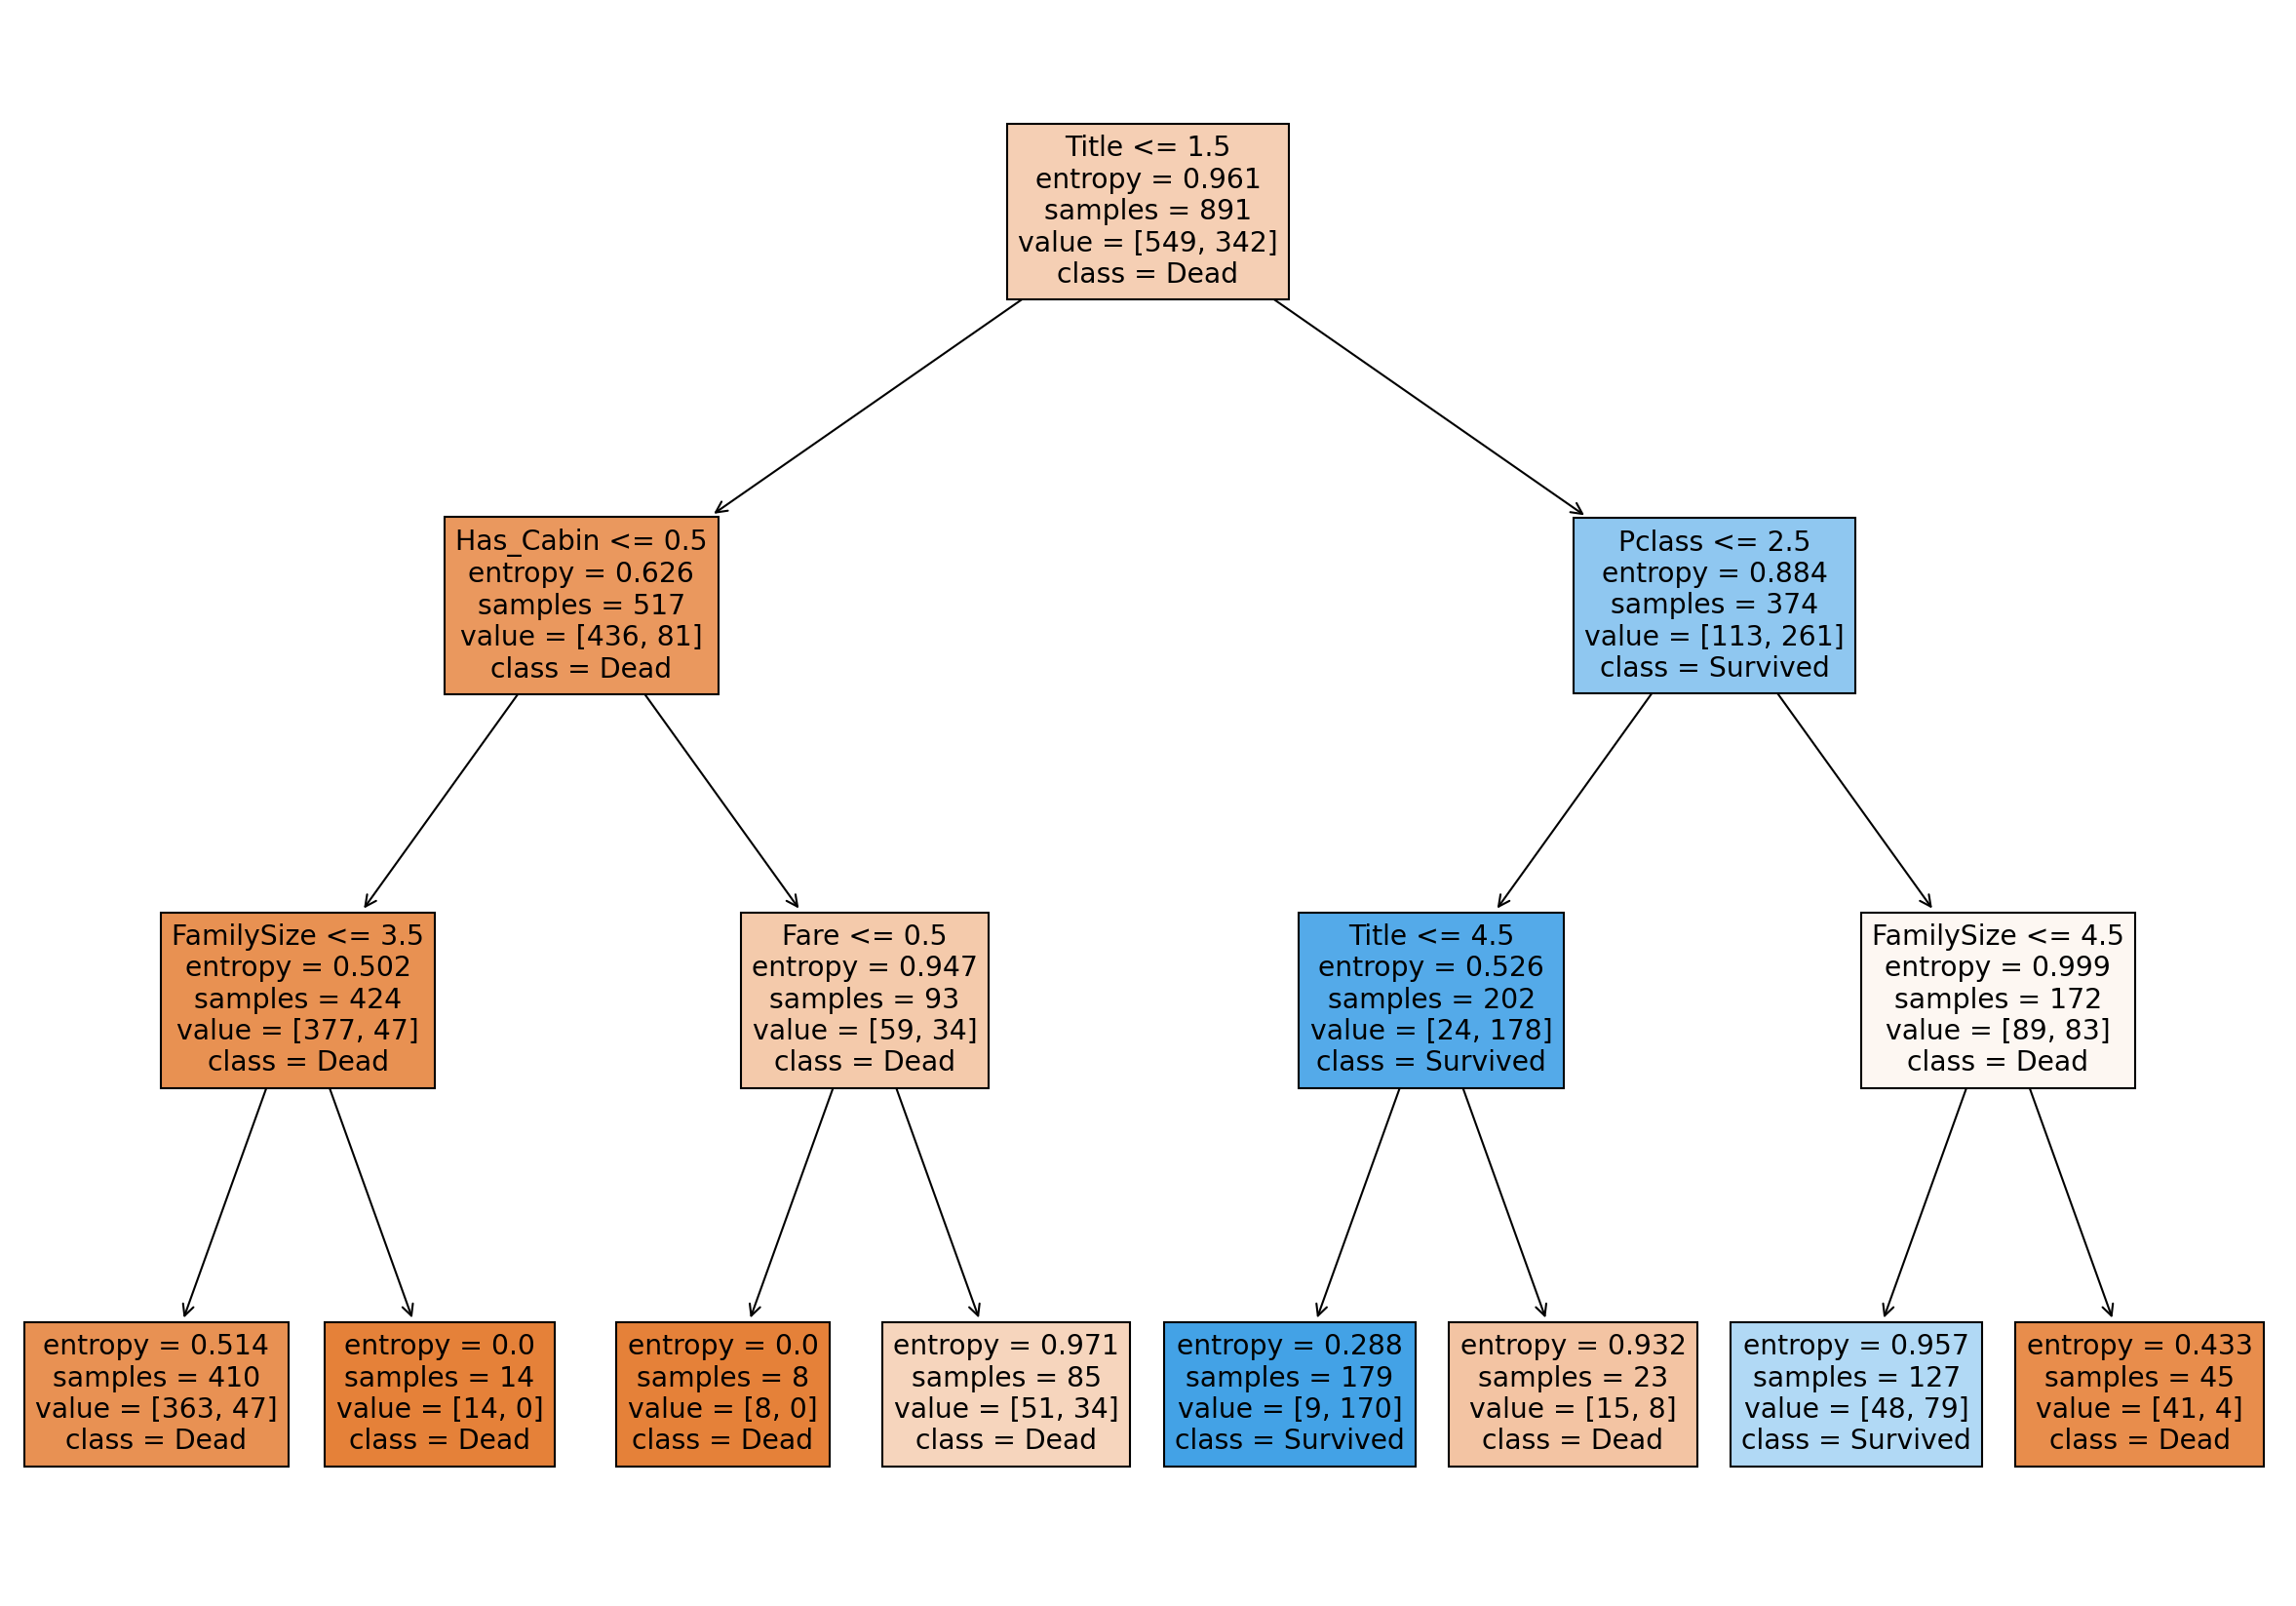

In [11]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 14))
plot_tree(decision_tree, feature_names=data_x.columns.tolist(), class_names=['Dead', 'Survived'], filled=True)

plt.gcf().set_dpi(150)
plt.show()

## Testowanie różnych parametrów drzewa

In [12]:
from sklearn.model_selection import cross_val_score

criterions = ['gini', 'entropy']
min_samples_leafs = [1, 10]
max_depths = [3, 5]

results = []

for criterion in criterions:
    for min_samples_leaf in min_samples_leafs:
        for max_depth in max_depths:
            decision_tree = tree.DecisionTreeClassifier(criterion=criterion,
                                                         min_samples_leaf=min_samples_leaf,
                                                         max_depth=max_depth)
            scores = cross_val_score(decision_tree, data_x, data_y, cv=10, scoring='accuracy')
            mean_score = scores.mean()
            params = {'criterion': criterion, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}
            results.append((mean_score, params))
            
for result in results:
    print("Średnia dokładność klasyfikacji:", result[0])
    print("Parametry:", result[1])
    print()

Średnia dokładność klasyfikacji: 0.8305243445692885
Parametry: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.8103245942571785
Parametry: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_depth': 5}

Średnia dokładność klasyfikacji: 0.8249063670411985
Parametry: {'criterion': 'gini', 'min_samples_leaf': 10, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.8047440699126092
Parametry: {'criterion': 'gini', 'min_samples_leaf': 10, 'max_depth': 5}

Średnia dokładność klasyfikacji: 0.8316479400749064
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.8282896379525593
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': 5}

Średnia dokładność klasyfikacji: 0.8316479400749064
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 10, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.817103620474407
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 10, 'm

Nieco lepsze wyniki klasyfikacji daje kryterium podziału `entropy`. Najlepsze rezultaty osiągnięto dla wartości parametrów `max_depth` =3 i `min_samples_leaf` = 1.

## Podział na zbiór treningowy i testowy

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
data_x, data_y, test_size=0.25, random_state=42)

## Macierz rozbieżności

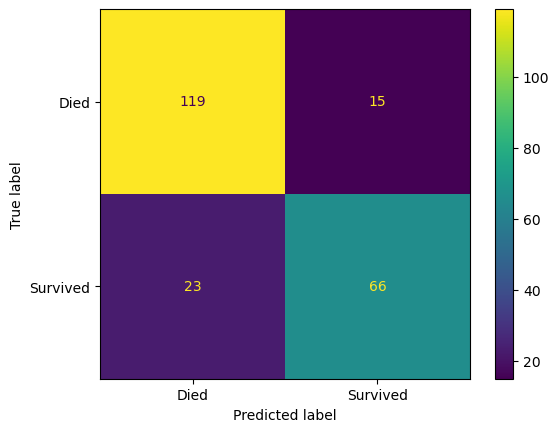

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

decision_tree = tree.DecisionTreeClassifier(max_depth = 3,
criterion='entropy')
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Died', 'Survived'])

cm_display.plot()
plt.show() 

## Miary dokładności klasyfikatora

In [15]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score

accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

avg_precision_recall = average_precision_score(y_test, y_pred)

print("Dokładność klasyfikatora:", accuracy)
print("F1-score:", f1)
print("Average precision-recall:", avg_precision_recall)


Dokładność klasyfikatora: 0.8295964125560538
F1-score: 0.7764705882352941
Average precision-recall: 0.7073837075852494


# Klasyfikator k-NN

## Breast Cancer Dataset

### Badanie dokładności klasyfikacji w zależności od wartości parametru k

In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier

# wczytanie danych
breast_cancer_data = load_breast_cancer()

# Podział na cechy (X) i etykiety (y)
X_bc = breast_cancer_data.data
y_bc = breast_cancer_data.target

# Zdefiniowanie różnych wartości parametru k
k_values = [1, 3, 5, 7]

# Inicjalizacja i trenowanie klasyfikatora KNN
for k in k_values:
    knn_bc = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_bc, X_bc, y_bc, cv=10, scoring='accuracy')
    mean_score = scores.mean()
    print("Dokładność klasyfikacji dla k =", k, ":", mean_score)


Dokładność klasyfikacji dla k = 1 : 0.9156954887218045
Dokładność klasyfikacji dla k = 3 : 0.9261904761904761
Dokładność klasyfikacji dla k = 5 : 0.9297619047619046
Dokładność klasyfikacji dla k = 7 : 0.9279761904761905


Najlepszy wynik dla k=5

### Badanie wpływu wprowadzenia wag odległości oraz innej miary odległości (Euklidesowa vs. Taxi) na rezultaty klasyfikacji

In [17]:
weights_values = ['uniform', 'distance'] 
metric_values = ['euclidean', 'manhattan']

# Inicjalizacja i ocena klasyfikatora KNN dla każdej kombinacji parametrów
for weights in weights_values:
    for metric in metric_values:
        knn_bc = KNeighborsClassifier(n_neighbors=5, weights=weights, metric=metric)
        scores = cross_val_score(knn_bc, X_bc, y_bc, cv=10, scoring='accuracy')
        mean_accuracy = scores.mean()
        print("Wagi:", weights, "- Metryka:", metric, "- Dokładność:", mean_accuracy)

Wagi: uniform - Metryka: euclidean - Dokładność: 0.9297619047619046
Wagi: uniform - Metryka: manhattan - Dokładność: 0.9332393483709271
Wagi: distance - Metryka: euclidean - Dokładność: 0.9297619047619046
Wagi: distance - Metryka: manhattan - Dokładność: 0.931484962406015


Metryka taksówkowa daje lepsze rezultaty niż euklidesowa. W przypadku metryki taksówkowej nieco lepsze wyniki są osiągane, gdy wszystkie punkty mają jednakową wagę (*uniform*). W przypadku metryki euklidesowej wagi odległości nie wpływaja na wyniki.

## NYT Dataset

### Badanie dokładności klasyfikacji w zależności od wartości parametru k

In [18]:
from sklearn.decomposition import PCA

# wczytanie danych
nyt_data = pd.read_csv('./nyt-frame.csv', header = 0)

# Podział na cechy (X) i etykiety (y)
X_nyt = nyt_data.iloc[:,9:]
y_nyt = nyt_data['class.labels']

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=10)
X_nyt_pca = pca.fit_transform(X_nyt)

# Inicjalizacja i trenowanie klasyfikatora KNN
for k in k_values:
    knn_nyt = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_nyt, X_nyt_pca, y_nyt, cv=10, scoring='accuracy')
    mean_score = scores.mean()
    print("Dokładność klasyfikacji dla k =", k, ":", mean_score)



Dokładność klasyfikacji dla k = 1 : 0.8800000000000001
Dokładność klasyfikacji dla k = 3 : 0.8718181818181818
Dokładność klasyfikacji dla k = 5 : 0.8627272727272727
Dokładność klasyfikacji dla k = 7 : 0.8627272727272729


Najlepszy wynik dla k=1

### Badanie wpływu wprowadzenia wag odległości oraz innej miary odległości (Euklidesowa vs. Taxi) na rezultaty klasyfikacji

In [19]:
for weights in weights_values:
    for metric in metric_values:
        knn_nyt = KNeighborsClassifier(n_neighbors=1, weights=weights, metric=metric)
        scores = cross_val_score(knn_nyt, X_nyt_pca, y_nyt, cv=10, scoring='accuracy')
        mean_accuracy = scores.mean()
        print("Wagi:", weights, "- Metryka:", metric, "- Dokładność:", mean_accuracy)

Wagi: uniform - Metryka: euclidean - Dokładność: 0.8800000000000001
Wagi: uniform - Metryka: manhattan - Dokładność: 0.8518181818181819
Wagi: distance - Metryka: euclidean - Dokładność: 0.8800000000000001
Wagi: distance - Metryka: manhattan - Dokładność: 0.8518181818181819


W tym przypadku lepsze rezultaty daje metryka euklidesowa. Wagi odległości nie wpływają na wyniki.

# Lasy losowe

## Titanic dataset

### Badanie wpływu różnych parametrów na dokładność klasyfikacji

In [20]:
from sklearn.ensemble import RandomForestClassifier

criterions = ['gini', 'entropy']
min_samples_leafs = [1, 10]
max_depths = [3, 5]

results = []

for criterion in criterions:
    for min_samples_leaf in min_samples_leafs:
        for max_depth in max_depths:
            random_forest = RandomForestClassifier(criterion=criterion,
                                                    min_samples_leaf=min_samples_leaf,
                                                    max_depth=max_depth,
                                                    random_state=42)
            scores = cross_val_score(random_forest, data_x, data_y, cv=10, scoring='accuracy')
            mean_score = scores.mean()
            params = {'criterion': criterion, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}
            results.append((mean_score, params))
            
for result in results:
    print("Średnia dokładność klasyfikacji:", result[0])
    print("Parametry:", result[1])
    print()


Średnia dokładność klasyfikacji: 0.8237952559300874
Parametry: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.8294007490636703
Parametry: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_depth': 5}

Średnia dokładność klasyfikacji: 0.8237952559300874
Parametry: {'criterion': 'gini', 'min_samples_leaf': 10, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.8271660424469414
Parametry: {'criterion': 'gini', 'min_samples_leaf': 10, 'max_depth': 5}

Średnia dokładność klasyfikacji: 0.8237952559300874
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.8327715355805243
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': 5}

Średnia dokładność klasyfikacji: 0.8237952559300874
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 10, 'max_depth': 3}

Średnia dokładność klasyfikacji: 0.8294132334581773
Parametry: {'criterion': 'entropy', 'min_samples_leaf': 10, '

W odróżnieniu od pojedynczego drzewa decyzyjnego las losowy osiąga najlepsze wyniki klasyfikacji dla `max_depth` = 5. Podobnie jak w przypadku drzewa decyzyjnego nieco lepsze rezultaty daje kryterium podziału `entropy`. Dla optymalnych parametrów las losowy osiąga nieznacznie wyższą dokładność klasyfikacji, jednak jest to różnica rzędu 0,001.

### Macierz rozbieżności

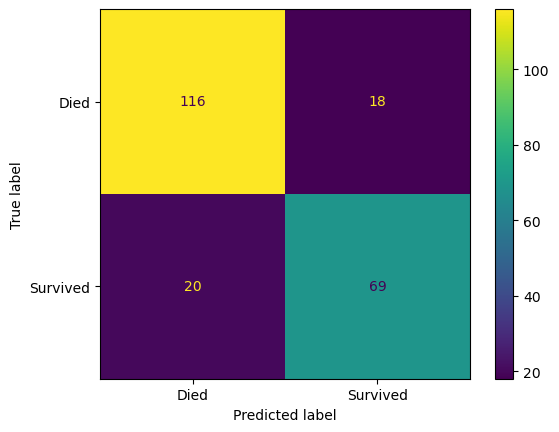

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

random_forest = RandomForestClassifier(max_depth = 5,
criterion='entropy')
random_forest.fit(X_train, y_train)
y_predicted = random_forest.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_predicted)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Died', 'Survived'])

cm_display.plot()
plt.show() 

W prównaniu z klasyfikacją za pomocą drzewa decyzyjnego:
- mniejsza liczba false negative (116 vs 119)
- większa liczba false positive (18 vs 15)
- mniejsza liczba true negative (20 vs 23)
- większa liczba true positive (69 vs 66)

### Mierzenie dokładności klasyfikatora

In [22]:
accuracy_rf = accuracy_score(y_test, y_predicted)

f1_rf = f1_score(y_test, y_predicted)

avg_precision_recall_rf = average_precision_score(y_test, y_predicted)

print("Dokładność klasyfikatora:", accuracy_rf)
print("F1-score:", f1_rf)
print("Average precision-recall:", avg_precision_recall_rf)

Dokładność klasyfikatora: 0.8251121076233184
F1-score: 0.7719298245614036
Average precision-recall: 0.7000148698519283


## Breast Cancer Dataset

### Badanie wpływu różnych parametrów na dokładność klasyfikacji

In [24]:
criterions = ['gini', 'entropy']
n_estimators = [50, 100, 150]
max_depths = [None, 5, 10]

results = []

for criterion in criterions:
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            random_forest = RandomForestClassifier(n_estimators=n_estimator,
                                                    criterion=criterion, 
                                                    max_depth=max_depth,
                                                    random_state=42)
            scores = cross_val_score(random_forest, X_bc, y_bc, cv=10, scoring='accuracy')
            mean_score = scores.mean()
            params = {'n_estimators': n_estimator, 'criterion': criterion, 'max_depth': max_depth}
            results.append((mean_score, params))
            
for result in results:
    print("Średnia dokładność klasyfikacji:", result[0])
    print("Parametry:", result[1])

Średnia dokładność klasyfikacji: 0.9613408521303256
Parametry: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': None}
Średnia dokładność klasyfikacji: 0.9596177944862155
Parametry: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 5}
Średnia dokładność klasyfikacji: 0.9613408521303256
Parametry: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 10}
Średnia dokładność klasyfikacji: 0.9631578947368421
Parametry: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': None}
Średnia dokładność klasyfikacji: 0.9613721804511279
Parametry: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5}
Średnia dokładność klasyfikacji: 0.9631578947368421
Parametry: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 10}
Średnia dokładność klasyfikacji: 0.9613721804511279
Parametry: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': None}
Średnia dokładność klasyfikacji: 0.9596177944862155
Parametry: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 5}
Średnia dokładno

Nieco lepsze wyniki daje kryterium podziału `entropy`. Najlepsze wyniki osiągnięto dla wartości parametrów `n_estimators` = 100, `max_depth` = 5.

### Badanie wpływu zastosowania PCA na osiągane rezultaty

In [25]:
pca = PCA(n_components=10)
X_bc_pca = pca.fit_transform(X_bc)

criterions = ['gini', 'entropy']
n_estimators = [50, 100, 150]
max_depths = [None, 5, 10]

results = []

for criterion in criterions:
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            random_forest = RandomForestClassifier(n_estimators=n_estimator,
                                                    criterion=criterion, 
                                                    max_depth=max_depth,
                                                    random_state=42)
            scores = cross_val_score(random_forest, X_bc_pca, y_bc, cv=10, scoring='accuracy')
            mean_score = scores.mean()
            params = {'n_estimators': n_estimator, 'criterion': criterion, 'max_depth': max_depth}
            results.append((mean_score, params))
            
for result in results:
    print("Średnia dokładność klasyfikacji:", result[0])
    print("Parametry:", result[1])

Średnia dokładność klasyfikacji: 0.9490601503759398
Parametry: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': None}
Średnia dokładność klasyfikacji: 0.9508771929824562
Parametry: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 5}
Średnia dokładność klasyfikacji: 0.9455200501253133
Parametry: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 10}
Średnia dokładność klasyfikacji: 0.9437969924812031
Parametry: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': None}
Średnia dokładność klasyfikacji: 0.9420112781954888
Parametry: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5}
Średnia dokładność klasyfikacji: 0.9437969924812031
Parametry: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 10}
Średnia dokładność klasyfikacji: 0.9437969924812031
Parametry: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': None}
Średnia dokładność klasyfikacji: 0.9420112781954886
Parametry: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 5}
Średnia dokładno

Zastosowanie PCA (wymiarowość zredukowana do 10) pogorszyło wyniki klasyfikacji o ok. 2%